# Some plots of Arcus ray-trace outputs

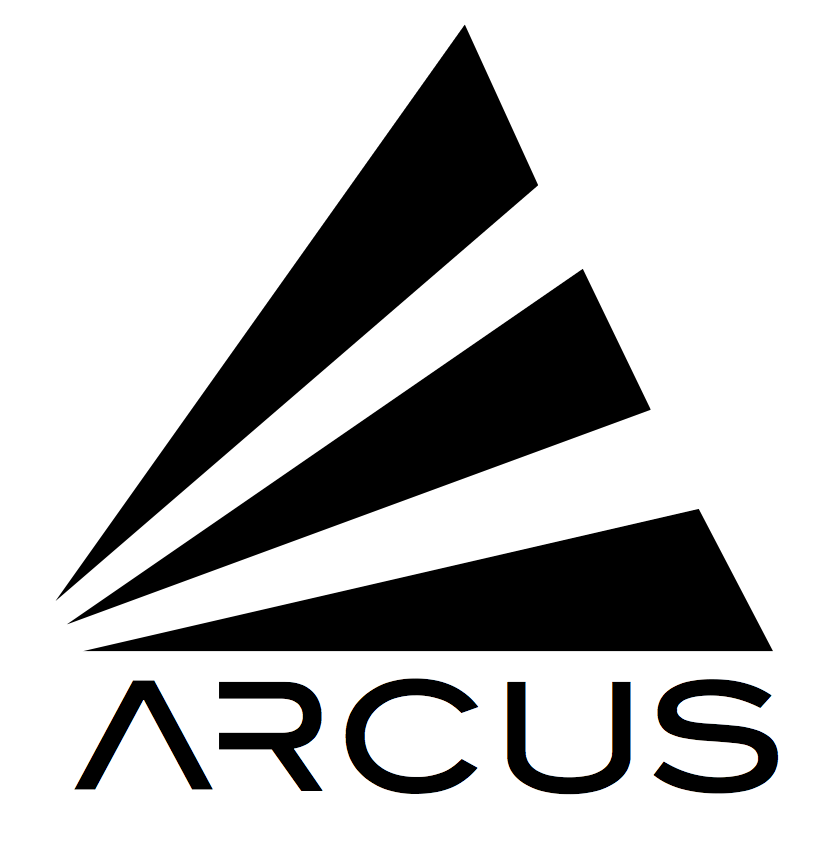

### Revision status: *draft*
Last revision in version control:

- Author: Hans Moritz Guenther <hgunther@mit.edu>
- commit 7a7f609e7f10d172c139f073c3360db0f8e5b666
- Date:   Wed Jan 3 16:53:40 2018 -0500

**The version shown here is modified compared to the last commited revision.**

            

This document is git version controlled. The repository is available at https://github.com/hamogu/arcus.
See git commit log for full revision history.

Code was last run with:

- MARXS ray-trace code version 1.2.dev643 (commit hash: c7a3e480d6 from 2018-05-31)
- ARCUS python code version 0.0.dev153 (commit hash: 3d289c95aa from 2018-02-07)
- ARCUS CALDB version hash: 5590a73 (commited on 2018-05-15 )


In [1]:
from nbtemplate import display_header, display_codetoggle, get_path
display_header('Plots.ipynb', status='draft')

## Purpose

The goal of this notebook is to show a few example outputs from ray-trace simulations to give a feel of how Arcus data will look. The goal of these plots is not to make the best possible prediction including all sorts of effects like sky background, instrumental background, bad pixels, read-out streaks, and charge transfer inefficiences - that sort of work is better done with the SIXTE simulation tool. Instead, the goal is to present a few results that show off the layout of the CCDs, the shape of the spectral traces etc.

## Emission line source
For this example, I chose the spectrum of EQ Peg A (an active star) with the parameters from [Liefke et al. (2008)](http://adsabs.harvard.edu/abs/2008A%26A...491..859L). In practice, there is a close companion EQ Peg B and the two spectra will overlap in ARCUS, but for the purposes of this example, EQ Peg A alone will be good enough to represent an emission line spectrum.

The code below reads the input spectrum from table of energy and flux density that I generated with Sherpa (could have used XSPEC or ISIS, too).

In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table
from matplotlib import ticker

%matplotlib inline

In [3]:
obs = Table.read(os.path.join(get_path('rays'), 'EQPegA100ks_evt.fits'))

Reading config file with path definitions: ['../site.cfg']


In [4]:
from arcus.arcus import defaultconf, DetCamera
det = DetCamera(defaultconf)

Reading config file with path definitions: ['../site.cfg']
Reading config file with path definitions: ['../site.cfg']


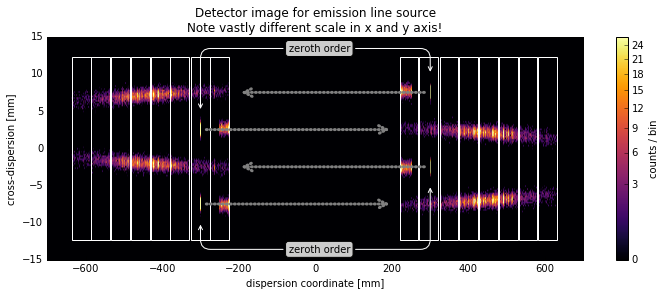

In [5]:
hist, xedges, yedges = np.histogram2d(obs['proj_x'], obs['proj_y'],
                            bins=[np.arange(-700, 700, 1), np.arange(-15, 15.01, .2)])

from astropy.visualization import (MinMaxInterval, AsymmetricPercentileInterval, SqrtStretch,
                                   ImageNormalize)
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

fig, (ax) = plt.subplots(figsize=(12, 4))

# Create an ImageNormalize object
norm = ImageNormalize(hist, interval=AsymmetricPercentileInterval(0, 99.9),
                      stretch=SqrtStretch())


cax = ax.imshow(hist.T, extent=[xedges.min(), xedges.max(), yedges.min(), yedges.max()],
                origin='lower', aspect='auto', 
                cmap=plt.get_cmap('inferno'),
                norm=norm)

for ccd in det.elements:
    # add a rectangle
    width = ccd.geometry('v_y')[0]
    height = ccd.geometry('v_z')[1]
    ax.add_patch(mpatches.Rectangle(ccd.geometry('center')[:2] - [width, height], 
                              width * 2, height * 2, fill=False, ec='w', fc="none"))

ax.set_xlabel("dispersion coordinate [mm]")
ax.set_ylabel('cross-dispersion [mm]')
ax.set_title('Detector image for emission line source\nNote vastly different scale in x and y axis!')


ax.annotate('zeroth order',
            xy=(300, 10), xycoords='data',
            xytext=(-70, 13), textcoords='data',
            bbox=dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=90,rad=10",
                            color='w'),
           )

ax.annotate('zeroth order',
            xy=(-300, 5), xycoords='data',
            xytext=(-70, 13), textcoords='data',
            bbox=dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=90,rad=10",
                            color='w'),
           )

ax.annotate('zeroth order',
            xy=(300, -5), xycoords='data',
            xytext=(-70, -14), textcoords='data',
            bbox=dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=90,rad=10",
                            color='w'),
           )

ax.annotate('zeroth order',
            xy=(-300, -10), xycoords='data',
            xytext=(-70, -14), textcoords='data',
            bbox=dict(boxstyle="round", fc="0.8"),
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle,angleA=0,angleB=90,rad=10",
                            color='w'),
           )

for chan in ['1', '2', '1m', '2m']:
    x, y = defaultconf['pos_opt_ax'][chan][:2]
    sig = -1 if 'm' in chan else 1
    ax.annotate("",
                xy=(x + sig * 500, y + 0), 
                xycoords='data',
                xytext=(x + sig * 10, y), textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3",
                                ls=':', lw=3, ec='0.5',
                               mutation_scale=20),
               )
#mpatches.FancyArrowPatch()
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('counts / bin')
#mpatches.PathPatch()
fig.savefig(os.path.join(get_path("figures"), 'EQFullDet.png'), bbox_inches='tight', dpi=300)
fig.savefig(os.path.join(get_path("figures"), 'EQFullDet.pdf'), bbox_inches='tight', dpi=300)

This plot shows an extremely distorted few of the CCD plane. Note that the $x$-axis extends of 1.2 m, while the $y$-axis covers only 2.5 cm. Each CCD is surrounded by a white frame. Due to the dimensions of the image, CCDs look high and narrow, but in reality they are twice as long in $x$ direction as in $y$ direction. Arcus has four separate channels, each with its own zero order location and dispersed trace. The positions of the zero orders are marked in the figure and gray arrows indicate the dispersion direction. 

Each spectral trace is slightly curved. This is the the result of astigmatism coupled with sub-aperturing. If each channel had a full 360$^\circ$ mirror, we would see an hour-glass shape that is narrowest at the position of the zeroth order and then widens as the spectral focus diverges from the imaging focus. In Arcus design with  tilted torus, there is a second point where the spectral focus coincides with the imaging focus and thus the spectral trace would become narrower in cross-dispersion direction again. However, the SPOs for each channel cover only a very small fraction of the full circle, and thus the spectral trace fills only one "edge" of the hourglass shape, which results in the curved image. The dispersion direction is exactly parallel to the $x$ axis at all locations, but the the $y$ extend of the extraction region can be chosen to follow the curve to reduce the number of background events in the spatial extraction region.

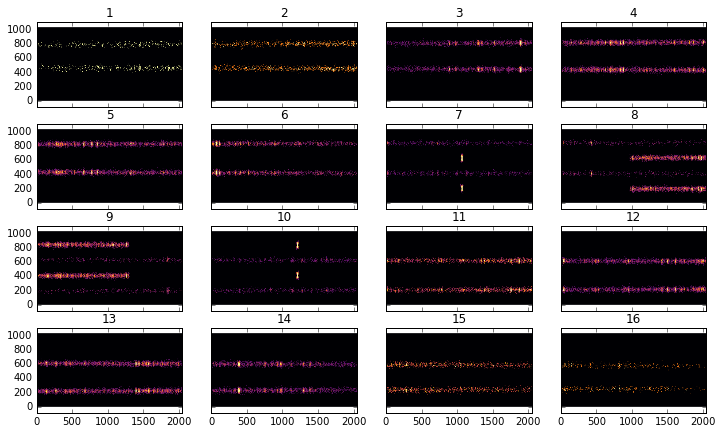

In [6]:
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, subplot_kw={'aspect': 'equal'}, figsize=(12, 7))

for i in range(16):
    ind = obs['CCD'] == i + 1
    hist, xedges, yedges = np.histogram2d(obs['detpix_x'][ind], obs['detpix_y'][ind],
                            bins=[np.arange(0, 2048, 8), np.arange(0, 1024, 8)])

    norm = ImageNormalize(hist, interval=AsymmetricPercentileInterval(0, 99.9),
                          stretch=SqrtStretch())

    ax = axes[np.unravel_index(i, axes.shape)]
    cax = ax.imshow(hist.T, extent=[0, 2048, 0, 1024],
                origin='lower', aspect='equal', 
                cmap=plt.get_cmap('inferno'),
                norm=norm)
    ax.set_xlim(0, 2048)
    ax.set_ylim(0, 1024)
    ax.set_title(i+1)

#cbar = fig.colorbar(cax, ax=ax)
#cbar.set_label('counts / bin')

This figure shows a more faithful representation of the Arcus data. Each panel shows a binned CCD image. The zeroth orders are seen on CCD 7 and 10 and the dispersed photons from the zeroth orders on CCD 7 run towards higher CCD numbers, those starting on CCD 10 towards lower CCD numbers. There is a gap in the simulation between the zeroth order in the middle of CCD 7 and the beginning of the dispersed spectrum on CCD 8. In this simulation only photons with a wavelength above $8\;\unicode{xC5}$ are included, because the CCD placement and CAT grating design is optimized in this range. In practice, some photons of shorter wavelengths would be detected inside this gap.

Reading config file with path definitions: ['../site.cfg']
Reading config file with path definitions: ['../site.cfg']


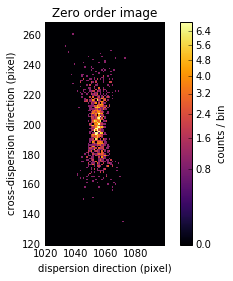

In [7]:
ind = obs['CCD'] == 7
hist, xedges, yedges = np.histogram2d(obs['detpix_x'][ind], obs['detpix_y'][ind],
                            bins=[np.arange(1020, 1100), np.arange(120, 270)])
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
# Create an ImageNormalize object
norm = ImageNormalize(hist, interval=AsymmetricPercentileInterval(0, 99.9),
                      stretch=SqrtStretch())


cax = ax.imshow(hist.T, extent=[xedges.min(), xedges.max(), 
                                yedges.min(), yedges.max()],
                origin='lower', aspect='equal', 
                interpolation='nearest',
                cmap=plt.get_cmap('inferno'),
                norm=norm)
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('counts / bin')
ax.set_title("Zero order image")
ax.set_ylabel("cross-dispersion direction (pixel)")
ax.set_xlabel("dispersion direction (pixel)")
ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
fig.savefig(os.path.join(get_path("figures"), 'EQZeroOrder.png'), bbox_inches='tight', dpi=300)
fig.savefig(os.path.join(get_path("figures"), 'EQZeroOrder.pdf'), bbox_inches='tight', dpi=300)

This picture shows a zoom into one on the zeroth orders which is roughly bow-tie shaped with most photons concentrated in the middle, where the structure is narrowest in the dispersion direction (left to right). The distribution becomes wider for $y$ coordinates further away from the center. Dispersed orders look similar in shape and this opens an interesting trade.

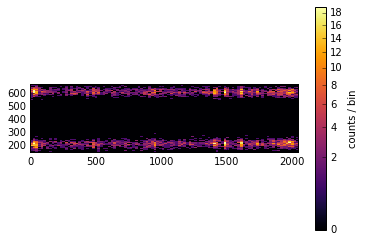

In [8]:
ind = obs['CCD'] == 12
hist, xedges, yedges = np.histogram2d(obs['detpix_x'][ind], obs['detpix_y'][ind], bins=100) #,
                            #bins=[np.arange(1020, 1100), np.arange(120, 270)])
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
# Create an ImageNormalize object
norm = ImageNormalize(hist, interval=AsymmetricPercentileInterval(0, 99.9),
                      stretch=SqrtStretch())


cax = ax.imshow(hist.T, extent=[xedges.min(), xedges.max(), 
                                yedges.min(), yedges.max()],
                origin='lower', aspect='equal', 
                interpolation='nearest',
                cmap=plt.get_cmap('inferno'),
                norm=norm)
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('counts / bin')

In [1]:
ind = obs['CCD'] == 12
hist, xedges, yedges = np.histogram2d(obs['detpix_x'][ind], obs['detpix_y'][ind],
                            bins=[np.arange(0, 200), np.arange(120, 270)])
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
# Create an ImageNormalize object
norm = ImageNormalize(hist, interval=AsymmetricPercentileInterval(0, 99.9),
                      stretch=SqrtStretch())


cax = ax.imshow(hist.T, extent=[xedges.min(), xedges.max(), 
                                yedges.min(), yedges.max()],
                origin='lower', aspect='equal', 
                interpolation='nearest',
                cmap=plt.get_cmap('inferno'),
                norm=norm)
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('counts / bin')
cbar.set_label('counts / bin')
ax.set_title("Continuum and lines in a spectrum")
ax.set_ylabel("cross-dispersion direction (pixel)")
ax.set_xlabel("dispersion direction (pixel)")
ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
fig.savefig(os.path.join(get_path("figures"), 'EQline.png'), bbox_inches='tight', dpi=300)
fig.savefig(os.path.join(get_path("figures"), 'EQline.pdf'), bbox_inches='tight', dpi=300)

NameError: name 'obs' is not defined

Reading config file with path definitions: ['../site.cfg']
Reading config file with path definitions: ['../site.cfg']


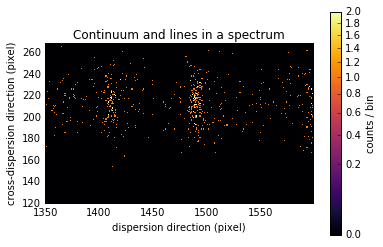

In [10]:
ind = obs['CCD'] == 12
hist, xedges, yedges = np.histogram2d(obs['detpix_x'][ind], obs['detpix_y'][ind],
                            bins=[np.arange(1350, 1600), np.arange(120, 270)])
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
# Create an ImageNormalize object
norm = ImageNormalize(hist, interval=AsymmetricPercentileInterval(0, 99.9),
                      stretch=SqrtStretch())


cax = ax.imshow(hist.T, extent=[xedges.min(), xedges.max(), 
                                yedges.min(), yedges.max()],
                origin='lower', aspect='equal', 
                interpolation='nearest',
                cmap=plt.get_cmap('inferno'),
                norm=norm)
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('counts / bin')
ax.set_title("Continuum and lines in a spectrum")
ax.set_ylabel("cross-dispersion direction (pixel)")
ax.set_xlabel("dispersion direction (pixel)")
fig.savefig(os.path.join(get_path("figures"), 'EQline2.png'), bbox_inches='tight', dpi=300)
fig.savefig(os.path.join(get_path("figures"), 'EQline2.pdf'), bbox_inches='tight', dpi=300)